In [1]:
# for performing GBDT
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from prettytable import PrettyTable
import re
from sklearn import tree
from tqdm import tqdm
import pickle
from scipy import sparse

In [3]:
# loading df_train (cleaned data)
df_train = pd.read_csv('df_train.csv')


In [4]:
#droping Unnamed column
df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_train.head(5)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,preprocessed_titles,preprocessed_essays,preprocessed_resource_summary,number_present
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,23,154.60,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,0
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,1,299.00,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,0
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,22,516.85,soccer equipment awesome middle school students,true champions not always ones win guts mia ha...,students need shine guards athletic socks socc...,0
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,4,1,4,232.90,techie kindergarteners,work unique school filled esl english second l...,students need engage reading math way inspire ...,0
4,mrs,tx,grades_prek_2,math_science,mathematics,1,1,4,67.98,interactive math tools,second grade classroom next year made around 2...,students need hands practice mathematics fun p...,0


In [5]:
#checking for null value
df_train.isnull().sum()

teacher_prefix                                   0
school_state                                     0
project_grade_category                           0
project_subject_categories                       0
project_subject_subcategories                    0
teacher_number_of_previously_posted_projects     0
project_is_approved                              0
quantity                                         0
price                                            0
preprocessed_titles                             43
preprocessed_essays                              0
preprocessed_resource_summary                    0
number_present                                   0
dtype: int64

preprocessed_title have 43 NULL values, we will drop the null row 

In [6]:
#index of rows having null values in preprocessed_title column 
row_drop=df_train[df_train['preprocessed_titles'].isnull()==True].index
row_drop

Int64Index([   880,   3517,   7503,   9019,   9518,  12390,  15617,  17652,
             17798,  18915,  19122,  19731,  19772,  21484,  24024,  25089,
             29208,  32089,  32608,  34091,  41656,  41797,  45844,  50004,
             50526,  54464,  54781,  56857,  57432,  59766,  63032,  68453,
             68821,  73774,  74264,  77851,  80909,  81581,  93213,  94369,
            101144, 102430, 106760],
           dtype='int64')

In [7]:
print('Shape of df_train before drop ',df_train.shape)

# droping the row 
df_train.drop(row_drop,axis=0,inplace=True)

print('Shape of df_train after drop ',df_train.shape)

Shape of df_train before drop  (109248, 13)
Shape of df_train after drop  (109205, 13)


In [8]:
#checking of data is balanced or not
df_train['project_is_approved'].value_counts()

1    92680
0    16525
Name: project_is_approved, dtype: int64

- data is imbalanced

# Sentiment scores

In [9]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rupes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
Sentiment_neg=[]
Sentiment_pos=[]
Sentiment_neu=[]
Sentiment_comp=[]


for k in tqdm(df_train['preprocessed_essays']):
    ss=sid.polarity_scores(k)
    for i,j in [(Sentiment_neg,'neg'),(Sentiment_pos,'pos'),(Sentiment_neu,'neu'),(Sentiment_comp,'compound')]:
        i.append(ss[j])

100%|█████████████████████████████████████████████████████████████████████████| 109205/109205 [03:16<00:00, 555.32it/s]


In [11]:
df_train['Sentiment_neg']=Sentiment_neg
df_train['Sentiment_pos']=Sentiment_pos
df_train['Sentiment_neu']=Sentiment_neu
df_train['Sentiment_comp']=Sentiment_comp

In [12]:
df_train.head(2)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,preprocessed_titles,preprocessed_essays,preprocessed_resource_summary,number_present,Sentiment_neg,Sentiment_pos,Sentiment_neu,Sentiment_comp
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,23,154.6,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,0,0.013,0.154,0.833,0.9694
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,1,299.0,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,0,0.052,0.305,0.643,0.9856


In [13]:
# creating dependent variable and independent varibale
X= df_train.drop('project_is_approved',axis=1)
Y=df_train['project_is_approved']

# splitting the data train , cross validation and test set 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, Y, test_size=0.33,stratify=Y)
X_train, X_cv, y_train, y_cv =train_test_split(X_train, y_train, test_size=0.33,stratify=y_train)


## 4. Response Coding

In [15]:
# combing y column for making row selection for response coding 
X_train['project_is_approved']=y_train
X_cv['project_is_approved']=y_cv
X_test['project_is_approved']=y_test

<ipython-input-15-e2e748461342>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['project_is_approved']=y_test


In [16]:
# list of cloumns on which we have to do Response Coding
# with new cloumns name of respective columns with each calss
list_of_categorical=[('teacher_prefix','teacher_prefix_class0','teacher_prefix_class1'),\
                     ('school_state','school_state_class0','school_state_class1'),\
                     ('project_grade_category','project_grade_category_class0','project_grade_category_class1'),\
                     ('project_subject_categories','project_subject_categories_class0','project_subject_categories_class1'),\
                     ('project_subject_subcategories','project_subject_subcategories_class0','project_subject_subcategories_class1')]

In [17]:
# iteration over the list 
for i in tqdm(list_of_categorical):
    
    
    print(i[0])
    
    # value counts for class 0 gives us number of time each category occur for class 0 
    ser0=X_train[X_train['project_is_approved']==0][i[0]].value_counts()
    
    
    #value counts for class 0 gives us number of time each category occur for class 0 
    ser1=X_train[X_train['project_is_approved']==1][i[0]].value_counts()
    
    # joining both pandas series with full outer join 
    # the category missing in any one class will be given NULL value
    ser=pd.concat([ser0,ser1],join='outer',axis=1,names=[0,1])
    
    # replacing NULL value with zero 
    ser=pd.DataFrame(ser.fillna(0))
    
    # list of all categories for the given feature
    category=np.array(ser.index)
    
    
    #storing the total number of time given category occur for given class
    sum_0=ser.iloc[:, 0].values
    sum_1=ser.iloc[:, 1].values
    
    #calculating probability for calss 0 
    prob0=sum_0/(sum_0+sum_1)
    
    #calculating probability for calss 1
    prob1=sum_1/(sum_0+sum_1)
    
    # creating dictionary with key as category and its probability as value for both class 0 and 1 
    dict0=dict(zip(category,prob0))
    dict1=dict(zip(category,prob1))
    
    # creating new column with suffix class0 and class1 for train set  
    X_train[i[1]]=[round(dict0.setdefault(val,0.5),4) for val in X_train[i[0]]] 

    X_train[i[2]]=[round(dict1.setdefault(val,0.5),4) for val in X_train[i[0]]] 
    
    # using the probability score for CV and test set
    X_cv[i[1]]=[round(dict0.setdefault(val,0.5),4) for val in X_cv[i[0]]] 

    X_cv[i[2]]=[round(dict1.setdefault(val,0.5),4) for val in X_cv[i[0]]] 
    
    X_test[i[1]]=[round(dict0.setdefault(val,0.5),4) for val in X_test[i[0]]] 

    X_test[i[2]]=[round(dict1.setdefault(val,0.5),4) for val in X_test[i[0]]]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

teacher_prefix


<ipython-input-17-5372d3259648>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i[1]]=[round(dict0.setdefault(val,0.5),4) for val in X_test[i[0]]]
<ipython-input-17-5372d3259648>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i[2]]=[round(dict1.setdefault(val,0.5),4) for val in X_test[i[0]]]
 20%|████████████████▊                                                                   | 1/5 [00:01<00:05,  1.28s/it]

school_state


 40%|█████████████████████████████████▌                                                  | 2/5 [00:02<00:03,  1.22s/it]

project_grade_category


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:03<00:02,  1.17s/it]

project_subject_categories


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:04<00:01,  1.15s/it]

project_subject_subcategories


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


In [18]:
X_train=X_train.drop('project_is_approved',axis=1)
X_cv=X_cv.drop('project_is_approved',axis=1)
X_test=X_test.drop('project_is_approved',axis=1)

# SET 1 :TFIDF

In [19]:
X_train.head(4)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,quantity,price,preprocessed_titles,preprocessed_essays,...,teacher_prefix_class0,teacher_prefix_class1,school_state_class0,school_state_class1,project_grade_category_class0,project_grade_category_class1,project_subject_categories_class0,project_subject_categories_class1,project_subject_subcategories_class0,project_subject_subcategories_class1
22613,mrs,mi,grades_prek_2,health_sports,health_wellness,16,6,353.94,target fit,students young energetic five six year olds lo...,...,0.1471,0.8529,0.1464,0.8536,0.1532,0.8468,0.1495,0.8505,0.1245,0.8755
99979,mrs,wa,grades_6_8,health_sports,health_wellness,31,9,79.94,help us balance work movement take 2,teach amazing eighth graders fun hardworking s...,...,0.1471,0.8529,0.1260,0.8740,0.1587,0.8413,0.1495,0.8505,0.1245,0.8755
66139,mrs,tx,grades_prek_2,literacy_language_math_science,literature_writing_mathematics,8,5,159.57,guided learning space,class 18 fun loving curious engaging kindergar...,...,0.1471,0.8529,0.1815,0.8185,0.1532,0.8468,0.1318,0.8682,0.1313,0.8687
22738,ms,ok,grades_prek_2,appliedlearning_literacy_language,earlydevelopment_literacy,0,2,399.99,teaching technology tiny thinkers,let see things hear students everyday teach 25...,...,0.1537,0.8463,0.1680,0.8320,0.1532,0.8468,0.1348,0.8652,0.1429,0.8571


# TFIDF of  preprocessed_essays

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)


#bag of word 
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape,y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)



After vectorizations
(49021, 5000) (49021,)
(24146, 5000) (24146,)
(36038, 5000) (36038,)


# TFIDF of preprocessed_titles

In [22]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['preprocessed_titles'].values) #fitting on train set 

x_train_title_tfidf=vectorizer.transform(X_train['preprocessed_titles'].values) # transforming train set 
X_cv_title_tfidf=vectorizer.transform(X_cv['preprocessed_titles'].values)  # transforming cross validation set 
X_test_title_tfidf=vectorizer.transform(X_test['preprocessed_titles'].values) # transforming test test 


print(X_cv_title_tfidf.shape)
print(X_cv_title_tfidf.shape)
print(X_test_title_tfidf.shape)



(24146, 3396)
(24146, 3396)
(36038, 3396)


# TFIDF of preprocessed_resource_summary

In [23]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)

vectorizer.fit(X_train['preprocessed_resource_summary'].values) #fitting on train set 

x_train_summ_tfidf=vectorizer.transform(X_train['preprocessed_resource_summary'].values) # transforming train set 
X_cv_summ_tfidf=vectorizer.transform(X_cv['preprocessed_resource_summary'].values)  # transforming cross validation set 
X_test_summ_tfidf=vectorizer.transform(X_test['preprocessed_resource_summary'].values) # transforming test test 


print(X_cv_summ_tfidf.shape)
print(X_cv_summ_tfidf.shape)
print(X_test_summ_tfidf.shape)




(24146, 5000)
(24146, 5000)
(36038, 5000)


# Concatenating all the features

In [24]:
#this code section is used as it is from given assignment description with some changes

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,x_train_title_tfidf,x_train_summ_tfidf,\
               X_train['school_state_class0'].values.reshape(-1,1),X_train['school_state_class1'].values.reshape(-1,1), \
               X_train['teacher_prefix_class0'].values.reshape(-1,1),X_train['teacher_prefix_class1'].values.reshape(-1,1), \
               X_train['project_grade_category_class0'].values.reshape(-1,1),X_train['project_grade_category_class1'].values.reshape(-1,1),\
               X_train['price'].values.reshape(-1,1),\
               X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_train['quantity'].values.reshape(-1,1),\
               X_train['project_subject_subcategories_class0'].values.reshape(-1,1),X_train['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_train['project_subject_categories_class0'].values.reshape(-1,1),X_train['project_subject_categories_class1'].values.reshape(-1,1),\
               X_train['Sentiment_neg'].values.reshape(-1,1),\
               X_train['Sentiment_pos'].values.reshape(-1,1),\
               X_train['Sentiment_neu'].values.reshape(-1,1),\
               X_train['Sentiment_comp'].values.reshape(-1,1),\
               X_train['number_present'].values.reshape(-1,1))).tocsr()


X_cr = hstack((X_cv_essay_tfidf,X_cv_title_tfidf,X_cv_summ_tfidf, \
               X_cv['school_state_class0'].values.reshape(-1,1),X_cv['school_state_class1'].values.reshape(-1,1), \
               X_cv['teacher_prefix_class0'].values.reshape(-1,1),X_cv['teacher_prefix_class1'].values.reshape(-1,1), \
               X_cv['project_grade_category_class0'].values.reshape(-1,1),X_cv['project_grade_category_class1'].values.reshape(-1,1),\
               X_cv['price'].values.reshape(-1,1),\
               X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_cv['quantity'].values.reshape(-1,1),\
               X_cv['project_subject_subcategories_class0'].values.reshape(-1,1),X_cv['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_cv['project_subject_categories_class0'].values.reshape(-1,1),X_cv['project_subject_categories_class1'].values.reshape(-1,1),\
               X_cv['Sentiment_neg'].values.reshape(-1,1),\
               X_cv['Sentiment_pos'].values.reshape(-1,1),\
               X_cv['Sentiment_neu'].values.reshape(-1,1),\
               X_cv['Sentiment_comp'].values.reshape(-1,1),\
               X_cv['number_present'].values.reshape(-1,1))).tocsr()



X_te = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_summ_tfidf,\
               X_test['school_state_class0'].values.reshape(-1,1),X_test['school_state_class1'].values.reshape(-1,1), \
               X_test['teacher_prefix_class0'].values.reshape(-1,1),X_test['teacher_prefix_class1'].values.reshape(-1,1), \
               X_test['project_grade_category_class0'].values.reshape(-1,1),X_test['project_grade_category_class1'].values.reshape(-1,1),\
               X_test['price'].values.reshape(-1,1),\
               X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_test['quantity'].values.reshape(-1,1),\
               X_test['project_subject_subcategories_class0'].values.reshape(-1,1),X_test['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_test['project_subject_categories_class0'].values.reshape(-1,1),X_test['project_subject_categories_class1'].values.reshape(-1,1),\
               X_test['Sentiment_neg'].values.reshape(-1,1),\
               X_test['Sentiment_pos'].values.reshape(-1,1),\
               X_test['Sentiment_neu'].values.reshape(-1,1),\
               X_test['Sentiment_comp'].values.reshape(-1,1),\
               X_test['number_present'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49021, 13414) (49021,)
(24146, 13414) (24146,)
(36038, 13414) (36038,)


# Hyperparameter tunning 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [39:12<00:00, 470.55s/it]


[Text(570.5454545454544, 0.5, 'learning_rate'),
 Text(0.5, 24.0, 'Number_of_model'),
 Text(0.5, 1.0, 'cv set')]

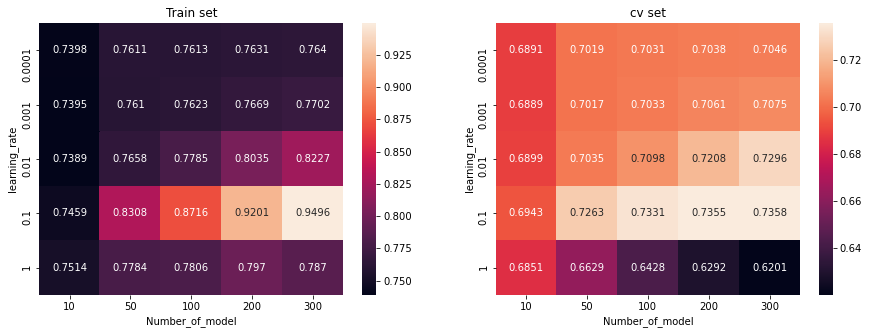

In [25]:
# grid search using simple for loop for different value of parameters

from sklearn.metrics import roc_auc_score
#list to store AUC score for different hyperparameter
train_auc = []
cv_auc = []

#parameters
Number_of_model= [10,50,100,200,300]
learning_rate=[0.0001,0.001,0.01,0.1,1]

for i in tqdm(Number_of_model):
    l_train=[]
    l_cv=[]
    for j in learning_rate:
           
        clf = xgb.XGBClassifier(n_estimators=i,learning_rate=j,booster='gbtree',subsample=0.5,colsample_bytree=0.5,reg_lambda=0.01,eval_metric= 'logloss',use_label_encoder=False)
        clf.fit(X_tr,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr)
        y_CV_proba=clf.predict_proba(X_cr)

        #storing the hyperparameter
        
        l_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        l_cv.append(roc_auc_score(y_cv,y_CV_proba[:,1]))
        
    train_auc.append(l_train)
    cv_auc.append(l_cv)

arr_train=np.asarray(train_auc)
arr_cv=np.asarray(cv_auc)

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(arr_train.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[0],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[1],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='cv set')


- At Number_of_model= 100
- At learning_rate =0.1

# Performing GBDT

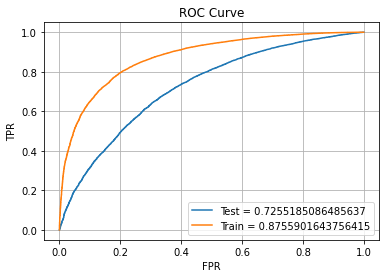

In [26]:
from sklearn import metrics
# for roc curve 



clf = xgb.XGBClassifier(objective ='binary:logistic',n_estimators=100,learning_rate=0.1,booster='gbtree',subsample=0.5,colsample_bytree=0.7,reg_lambda=0.01,eval_metric= 'logloss',\
                       use_label_encoder=False)
clf.fit(X_tr,y_train)
    
#predicting the probability score for train and cross validate set 
y_test_proba=clf.predict_proba(X_te)
y_train_proba=clf.predict_proba(X_tr)
test_AUC_score_tfidf=roc_auc_score(y_test,y_test_proba[:,1])
train_AUC_score_tfidf=roc_auc_score(y_train,y_train_proba[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_proba[:,1], pos_label=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train,y_train_proba[:,1], pos_label=1)

plt.plot(fpr,tpr,label='Test = '+str(test_AUC_score_tfidf))
plt.plot(fpr1,tpr1,label='Train = '+str(train_AUC_score_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

# Confusion matrix

Text(0.5, 1.0, 'Cnfusion Matrix')

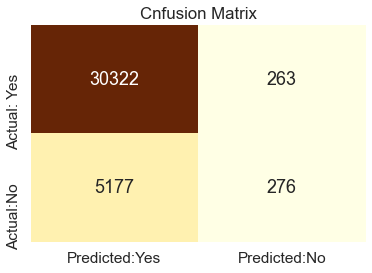

In [28]:
from sklearn.metrics import confusion_matrix

y_test_ped=clf.predict(X_te)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')






# SET:2 TFIDF W2V

In [29]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# TFIDF W2V preprocessed_essays


In [30]:
#creating tfidf vector on train data set
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [31]:
#this code is taken from assignment description
# average Word2Vec
# compute average word2vec for each review.
# for essay train data set
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49021/49021 [03:22<00:00, 242.61it/s]

49021
300


In [32]:
#for essay cv data set
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24146/24146 [01:40<00:00, 241.03it/s]

24146
300


In [33]:
# for essay test data set
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36038/36038 [02:35<00:00, 231.57it/s]

36038
300


# TFIDF W2V TITLE

In [34]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [35]:
#creating list for storing the vectors 
tfidf_w2v_title_train=[]
tfidf_w2v_title_cv=[]
tfidf_w2v_title_test=[]



for i,j in [(tfidf_w2v_title_train,X_train),(tfidf_w2v_title_cv,X_cv),(tfidf_w2v_title_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['preprocessed_titles'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('/n')

  5%|███▋                                                                      | 1212/24146 [00:00<00:02, 11297.89it/s]

49021
300
/n


  5%|███▌                                                                      | 1720/36038 [00:00<00:02, 16741.09it/s]

24146
300
/n


100%|█████████████████████████████████████████████████████████████████████████| 36038/36038 [00:02<00:00, 15783.56it/s]

36038
300
/n


# TFIDF W2V OF resource_summary

In [36]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_resource_summary'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [37]:
tfidf_w2v_summ_train=[]
tfidf_w2v_summ_cv=[]
tfidf_w2v_summ_test=[]

for i,j in [(tfidf_w2v_summ_train,X_train),(tfidf_w2v_summ_cv,X_cv),(tfidf_w2v_summ_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['preprocessed_resource_summary'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('\n')

  3%|██                                                                          | 660/24146 [00:00<00:03, 6562.67it/s]

49021
300




  3%|██                                                                         | 1004/36038 [00:00<00:07, 4677.64it/s]

24146
300




100%|██████████████████████████████████████████████████████████████████████████| 36038/36038 [00:06<00:00, 5167.89it/s]

36038
300




# Concatenating columns

In [38]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_train)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_train)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_train)),\
               X_train['school_state_class0'].values.reshape(-1,1),X_train['school_state_class1'].values.reshape(-1,1), \
               X_train['teacher_prefix_class0'].values.reshape(-1,1),X_train['teacher_prefix_class1'].values.reshape(-1,1), \
               X_train['project_grade_category_class0'].values.reshape(-1,1),X_train['project_grade_category_class1'].values.reshape(-1,1),\
               X_train['price'].values.reshape(-1,1),\
               X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_train['quantity'].values.reshape(-1,1),\
               X_train['project_subject_subcategories_class0'].values.reshape(-1,1),X_train['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_train['project_subject_categories_class0'].values.reshape(-1,1),X_train['project_subject_categories_class1'].values.reshape(-1,1),\
               X_train['number_present'].values.reshape(-1,1))).tocsr()


X_cr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_cv)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_cv)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_cv)),\
               X_cv['school_state_class0'].values.reshape(-1,1),X_cv['school_state_class1'].values.reshape(-1,1), \
               X_cv['teacher_prefix_class0'].values.reshape(-1,1),X_cv['teacher_prefix_class1'].values.reshape(-1,1), \
               X_cv['project_grade_category_class0'].values.reshape(-1,1),X_cv['project_grade_category_class1'].values.reshape(-1,1),\
               X_cv['price'].values.reshape(-1,1),\
               X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_cv['quantity'].values.reshape(-1,1),\
               X_cv['project_subject_subcategories_class0'].values.reshape(-1,1),X_cv['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_cv['project_subject_categories_class0'].values.reshape(-1,1),X_cv['project_subject_categories_class1'].values.reshape(-1,1),\
               X_cv['number_present'].values.reshape(-1,1))).tocsr()



X_te = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_test)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_test)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_test)),\
               X_test['school_state_class0'].values.reshape(-1,1),X_test['school_state_class1'].values.reshape(-1,1), \
               X_test['teacher_prefix_class0'].values.reshape(-1,1),X_test['teacher_prefix_class1'].values.reshape(-1,1), \
               X_test['project_grade_category_class0'].values.reshape(-1,1),X_test['project_grade_category_class1'].values.reshape(-1,1),\
               X_test['price'].values.reshape(-1,1),\
               X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_test['quantity'].values.reshape(-1,1),\
               X_test['project_subject_subcategories_class0'].values.reshape(-1,1),X_test['project_subject_subcategories_class1'].values.reshape(-1,1),\
               X_test['project_subject_categories_class0'].values.reshape(-1,1),X_test['project_subject_categories_class1'].values.reshape(-1,1),\
               X_test['number_present'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49021, 914) (49021,)
(24146, 914) (24146,)
(36038, 914) (36038,)


# Hyperparameter Tuning 

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:05:03<00:00, 2220.64s/it]


[Text(564.0454545454544, 0.5, 'learning_rate'),
 Text(0.5, 17.5, 'Number_of_model'),
 Text(0.5, 1.0, 'cv set')]

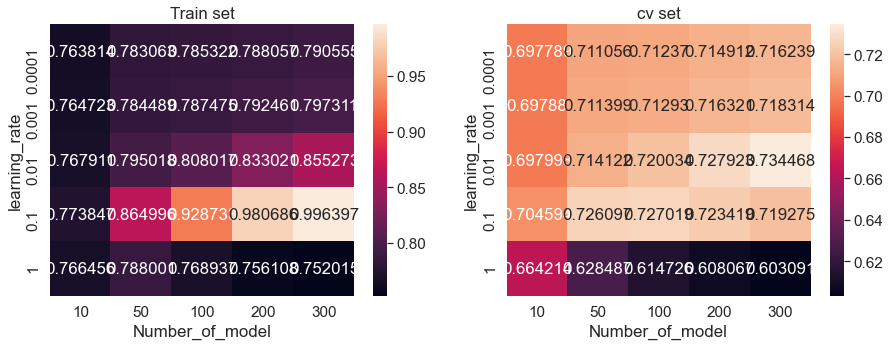

In [39]:

from sklearn.metrics import roc_auc_score
#list to store AUC score for different hyperparameter
train_auc = []
cv_auc = []

#parameters
Number_of_model= [10,50,100,200,300]
learning_rate=[0.0001,0.001,0.01,0.1,1]


for i in tqdm(Number_of_model):
    l_train=[]
    l_cv=[]
    for j in learning_rate:
        
        clf = xgb.XGBClassifier(n_estimators=i,learning_rate=j,booster='gbtree',subsample=0.5,colsample_bytree=0.7,reg_lambda=0.001,eval_metric= 'logloss',use_label_encoder=False)
        clf.fit(X_tr,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr)
        y_CV_proba=clf.predict_proba(X_cr)

        #storing the hyperparameter
        
        l_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        l_cv.append(roc_auc_score(y_cv,y_CV_proba[:,1]))
        
    train_auc.append(l_train)
    cv_auc.append(l_cv)

arr_train=np.asarray(train_auc)
arr_cv=np.asarray(cv_auc)

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(arr_train.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[0],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[1],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='cv set')


## Heat map

- At Number_of_model= 100
- At learning_rate =0.1

# Performing GBDT

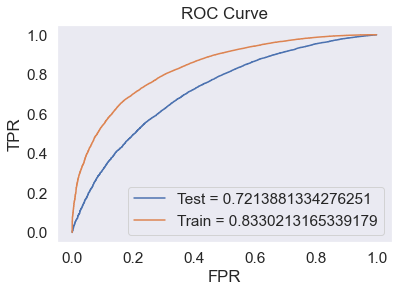

In [40]:
from sklearn import metrics
# for roc curve 


clf = xgb.XGBClassifier(n_estimators=200,learning_rate=0.01,booster='gbtree',subsample=0.5,colsample_bytree=0.7,reg_lambda=0.001,eval_metric= 'logloss',use_label_encoder=False)
clf.fit(X_tr,y_train)
    
#predicting the probability score for train and cross validate set 
y_test_proba=clf.predict_proba(X_te)
y_train_proba=clf.predict_proba(X_tr)
test_AUC_score_tfidf_w2v=roc_auc_score(y_test,y_test_proba[:,1])
train_AUC_score_tfidf=roc_auc_score(y_train,y_train_proba[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_proba[:,1], pos_label=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train,y_train_proba[:,1], pos_label=1)

plt.plot(fpr,tpr,label='Test = '+str(test_AUC_score_tfidf_w2v))
plt.plot(fpr1,tpr1,label='Train = '+str(train_AUC_score_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

# confusion matrix

Text(0.5, 1.0, 'Cnfusion Matrix')

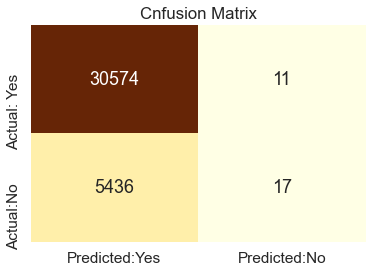

In [41]:
from sklearn.metrics import confusion_matrix

y_test_ped=clf.predict(X_te)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')


# PrettyTable

In [43]:
# from prettytable import PrettyTable

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer","Model", "MAX DEPTH","MIN SAMPLE SPLIT","AUC"]

x.add_row(['TFIDF','GBDT',100,0.1,test_AUC_score_tfidf])

x.add_row(['TFIDF AVG W2V','GBDT',200,0.01,test_AUC_score_tfidf_w2v])

print('Tabel')
print(x)

Tabel
+---------------+-------+-----------+------------------+--------------------+
|   Vectorizer  | Model | MAX DEPTH | MIN SAMPLE SPLIT |        AUC         |
+---------------+-------+-----------+------------------+--------------------+
|     TFIDF     |  GBDT |    100    |       0.1        | 0.7255185086485637 |
| TFIDF AVG W2V |  GBDT |    200    |       0.01       | 0.7213881334276251 |
+---------------+-------+-----------+------------------+--------------------+
